# GFP only

In [43]:
import random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = True  # False = only synonymous; True = allow both


# Input file
GFP_FASTA = Path("/Users/ishaharris/Projects/ribolings/data/MaxMono_GFP.fasta")   # change path if needed

# Simulation parameters
GENERATIONS = 1000      # accepted synonymous mutations
SAMPLE_EVERY = 1       # record frequencies every N accepted mutations
BIAS_TRANSITION = 3.0    # transition:transversion ratio


In [44]:
# Standard genetic code (DNA codons -> amino acids)
genetic_code = {
    "TTT":"F","TTC":"F",
    "TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I",
    "ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y",
    "CAT":"H","CAC":"H",
    "CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N",
    "AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D",
    "GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C",
    "TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}


In [45]:
from pathlib import Path

def parse_fasta(filename: Path):
    records = {}
    header = None
    seq_chunks = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def translate(cds: str):
    aa = []
    for i in range(0, len(cds), 3):
        codon = cds[i:i+3]
        aa.append(genetic_code.get(codon, "?"))
    return "".join(aa)


records = parse_fasta(GFP_FASTA)
name, cds = next(iter(records.items()))  # first key,value only


name, cds = next((k,v) for k,v in records.items() if v)

aa_seq = translate(cds)

print(f"Loaded sequence: {name}")
print(f"Length (nt): {len(cds)} | Length (aa): {len(aa_seq)}")


Loaded sequence: Recoded_Balanced_Mono
Length (nt): 717 | Length (aa): 239


In [46]:
records

{'Recoded_Balanced_Mono': 'ATGTCCAAGGGTGAAGAACTCTTCACTGGCGTCGTCCCAATTCTAGTAGAGCTCGATGGCGATGTCAACGGTCATAAATTCTCCGTCAGCGGAGAAGGTGAAGGCGATGCTACTTACGGCAAACTTACTCTCAAGTTCATCTGCACTACGGGTAAGCTCCCTGTTCCATGGCCAACTTTGGTAACGACGTTAACGTACGGTGTCCAATGCTTCAGCAGATACCCGGATCATATGAAGCAGCATGATTTCTTCAAGTCGGCGATGCCGGAGGGTTACGTCCAAGAACGTACTATCTTCTTCAAGGACGACGGTAACTACAAGACTCGTGCTGAGGTCAAGTTCGAGGGCGATACTCTCGTCAATCGTATCGAGCTCAAGGGTATCGACTTCAAGGAGGACGGTAACATCCTTGGCCATAAGCTTGAGTACAACTACAATTCCCATAATGTCTACATCATGGCGGACAAGCAGAAGAATGGTATCAAGGTCAACTTCAAGATCCGTCATAACATCGAGGATGGCTCTGTCCAGCTTGCTGACCATTACCAGCAGAATACTCCGATTGGTGATGGCCCTGTTCTGCTGCCGGATAATCATTACCTGTCGACGCAGTCGGCTTTGTCGAAGGACCCTAATGAGAAGCGTGATCATATGGTCCTCCTGGAGTTCGTCACCGCTGCTGGTATCACGCTGGGTATGGACGAGCTCTACAAGTAG',
 'MaxA_Targeted': 'ATGTCAAAAGGAGAAGAATTATTTACAGGAGTAGTACCAATATTAGTAGAATTAGATGGAGATGTAAATGGACATAAATTTTCAGTATCAGGAGAAGGAGAAGGAGATGCAACATATGGAAAATTAACATTAAAATTTATATGTACAACAGGAAAATTACCAGTACCATGGCCAACATTAGTAACAACATTAACATATGGAGTACAATGTTTTTCAAGATATCCAGATCATATG

In [47]:
def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds)
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def synonymous_mutation_step(cds, bias_transition=3.0, max_tries=2000):
    L = len(cds)
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        old_codon = cds[cs:cs+3]
        new_codon = mutated[cs:cs+3]
        if genetic_code.get(new_codon) == genetic_code.get(old_codon):
            return mutated, True
    return cds, False


In [48]:

def mutation_step(cds, allow_nonsynonymous=False, bias_transition=3.0, max_tries=2000):
    """
    Try one point mutation on `cds`.
    - If allow_nonsynonymous=False: accept only synonymous mutations (up to max_tries).
    - If allow_nonsynonymous=True: accept the first proposed mutation (single try).
    Returns: (new_cds, accepted_bool)
    """
    L = len(cds)
    if L < 3:
        return cds, False  # too short to define codons

    if allow_nonsynonymous:
        # Single biased mutation; accept regardless of amino-acid change
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            return cds, False
        mutated = cds[:pos] + newb + cds[pos+1:]
        return mutated, True

    # Synonymous-only mode: keep trying until a silent change is found or we give up
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            continue
        mutated = cds[:pos] + newb + cds[pos+1:]

        # Identify the affected codon and check if the AA is unchanged
        cs = (pos // 3) * 3
        old_codon = cds[cs:cs+3]
        new_codon = mutated[cs:cs+3]
        if genetic_code.get(new_codon) == genetic_code.get(old_codon):
            return mutated, True

    return cds, False


In [49]:
history_times = [0]
history_freqs = [nucleotide_freqs(cds)]
accepted = 0

for gen in range(1, GENERATIONS+1):
    cds, ok = mutation_step(
        cds,
        allow_nonsynonymous=ALLOW_NONSYNONYMOUS,
        bias_transition=BIAS_TRANSITION,
        max_tries=2000
    )
    if ok:
        accepted += 1
    if gen % SAMPLE_EVERY == 0:
        history_times.append(gen)
        history_freqs.append(nucleotide_freqs(cds))


print(f"Accepted synonymous mutations: {accepted}")
print("Initial frequencies:", history_freqs[0])


Accepted synonymous mutations: 1000
Initial frequencies: {'A': 0.25662482566248257, 'C': 0.24546722454672246, 'G': 0.2510460251046025, 'T': 0.24686192468619247}


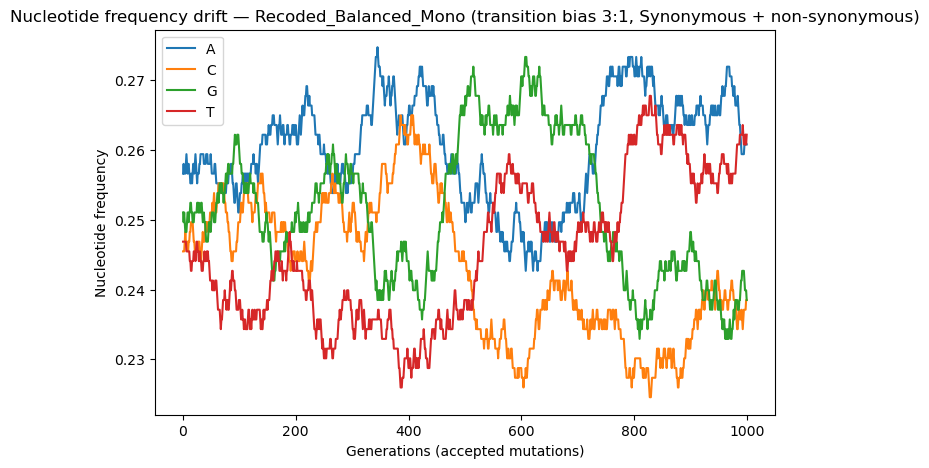

In [50]:
# Label based on config
mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"

A = [d["A"] for d in history_freqs]
C = [d["C"] for d in history_freqs]
G = [d["G"] for d in history_freqs]
T = [d["T"] for d in history_freqs]

plt.figure(figsize=(8,5))
plt.plot(history_times, A, label="A")
plt.plot(history_times, C, label="C")
plt.plot(history_times, G, label="G")
plt.plot(history_times, T, label="T")
plt.xlabel("Generations (accepted mutations)")
plt.ylabel("Nucleotide frequency")
plt.title(f"Nucleotide frequency drift — {name} "
          f"(transition bias 3:1, {mode_label})")
plt.legend()
plt.show()


# Run simulation 500 times, plot the final freqs

/var/folders/ls/vwbn46k51_dbtpbp9vjn8kzh0000gq/T/ipykernel_21898/668513190.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


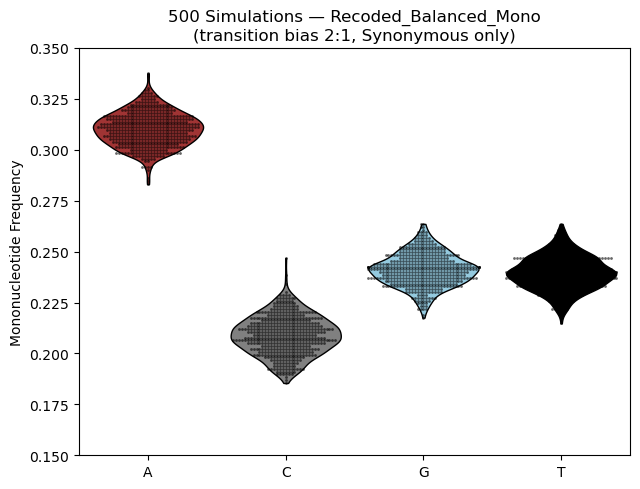

In [ ]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Config ----
N_SIM = 500
GENERATIONS = 10000
BIAS_TRANSITION = 3
ALLOW_NONSYNONYMOUS = False  # True = syn + non-syn; False = syn-only
PALETTE = {"A": "firebrick", "C": "grey", "G": "skyblue", "T": "black"}

# Load the first sequence from FASTA
records = parse_fasta(GFP_FASTA)
name, start_cds = next(iter(records.items()))

def simulate_once(start_seq, generations, allow_nonsynonymous, bias_transition):
    """Run one simulation from start_seq; return the final nucleotide frequencies."""
    cds = start_seq
    for _ in range(generations):
        cds, _ok = mutation_step(
            cds,
            allow_nonsynonymous=allow_nonsynonymous,
            bias_transition=bias_transition,
            max_tries=2000
        )
    return nucleotide_freqs(cds)

# ---- Run sims ----
final_freqs = [
    simulate_once(
        start_seq=start_cds,
        generations=GENERATIONS,
        allow_nonsynonymous=ALLOW_NONSYNONYMOUS,
        bias_transition=BIAS_TRANSITION
    )
    for _ in range(N_SIM)
]

# ---- Tidy to long DataFrame for seaborn ----
df = pd.DataFrame(final_freqs)              # columns: A C G T
df_melt = df.melt(var_name="Nucleotide", value_name="Frequency")

mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"

# ---- Violin + swarm ----
plt.figure(figsize=(6.5, 5))
sns.violinplot(
    data=df_melt, x="Nucleotide", y="Frequency",
    palette=PALETTE, inner=None, cut=0, linewidth=1
)
sns.swarmplot(
    data=df_melt, x="Nucleotide", y="Frequency",
    color="k", size=2, alpha=0.6
)

plt.title(f"{N_SIM} Simulations — {name}\n"
          f"(transition bias {BIAS_TRANSITION}:1, {mode_label})")
plt.ylabel("Mononucleotide Frequency")
plt.xlabel("")
# Optional fixed y-limits like the example:
plt.ylim(0.15, 0.35)

plt.tight_layout()
plt.show()


# Notes

1. understand what's actually going on here (e.g. what do we do with stop codons?) plot the freq of these arising

what is the nt frequency of wt gfp?
- apparently 29%

check this with various other genes. if we first recode to be equal, then nt frequency drift, do they return to wt nucleotide bias?

profile the frequency of stop codons arising 

# Run simulation for lots of genes

Inspect fastas

In [1]:
from Bio import SeqIO

fasta_file = "/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta/Calici.fasta"

for record in SeqIO.parse(fasta_file, "fasta"):
    print(record.id)        # sequence ID
    print(record.seq)       # sequence string
    print(record.description)  # full header line


lcl|AF182760.1_cds_AAF04560.1_1
ATGGCTAATTGCCGTCCGTTGCCTATTGGGCAGTTGCCCAACAGGATTTTTGACACCCCACGACTCACCCCAGGGTGGGTGTGGGCGTGCACGAGTGAAGCCACGTTTAAGTTGGAATGGCTTCAGGATCCGGTGGTCATTCGACCCCCGGACGTGTTTGTGGCGCAAGGGGTGGTGGATGATTTCTTCCGCCCCAAGCGCGTTTTGCAGGGCGACCCGCAACTCATCGCACAGGTCCTGCTTGGTGACGCCAATGGACCACTGGTTGGCCCTGTGTCCATGCAGCAACTGACATCACTGTTGCATGAGGTGTCGCAGGCCCTAAGTGACCACAAGCACCCACTGGCCAACAGATACACTAGGGCCTCTTTGCAGAGGTATGCTGACACCTTGTCCAATTACATACCTCTTGTGGACATTCTAACAGGACCAAAGGACCTTACCCCACGTGACGTTCTTGAACAGCTCGCAGCAGGACGTGAGTGGGAGTGTGTGCCAGATAGTGCTCTGAAGAAGGTTTTCAGGGACATGTGGCAGTACATTTGTGAGGGGTGCGACAGTGTGTACATAAAGCTTCAGGACGTGAAGCGCAAAATGCCACACATTGACACCACTGTGCTGAAACAATTCATTATCACACTGACAGATACCATCTCCATGGCAACAGCCTTAGACACCAAAACGTGGCTTGCGCACATTCTGGGTTGGCTCAAACCCACCTGTTTGGTGATGATCATGCAACAACATGTCAACTCCCCCCAGGGGTGGGCTGCCACGTTAACTGCTTTGGCAGAGCTGTATTATGGCATCATGCCATTAACAGAAACACTTGGTTCTGTTGCCAGCTGGGTGACTGACAAATTTGCTGACATGGCGACTAGCACCTGGGGCAAATTCAAATCCTGGTGGGACAGCCTCTACACGCCGCAGGCAGGCAATGATCTCATCATATTGGGGGGCGTTGTTGG

Run simulation

[INFO] Loaded 1 sequence(s) from: /Users/ishaharris/Projects/ribolings/data/wtGFP.fasta
[START] 1/1 'lcl|M62653.1_cds_AAA27721.1_1 [gene=GFP] [protein=green-fluorescent protein] [protein_id=AAA27721.1] [location=26..742] [gbkey=CDS]': nt=717, aa=239 | mode=Synonymous only
        Progress:
          - 10% (1000/10000) | accepted=1000
          - 20% (2000/10000) | accepted=2000
          - 30% (3000/10000) | accepted=3000
          - 40% (4000/10000) | accepted=4000
          - 50% (5000/10000) | accepted=5000
          - 60% (6000/10000) | accepted=6000
          - 70% (7000/10000) | accepted=7000
          - 80% (8000/10000) | accepted=8000
          - 90% (9000/10000) | accepted=9000
          - 100% (10000/10000) | accepted=10000
[DONE ] 'lcl|M62653.1_cds_AAA27721.1_1 [gene=GFP] [protein=green-fluorescent protein] [protein_id=AAA27721.1] [location=26..742] [gbkey=CDS]': total accepted mutations = 10000


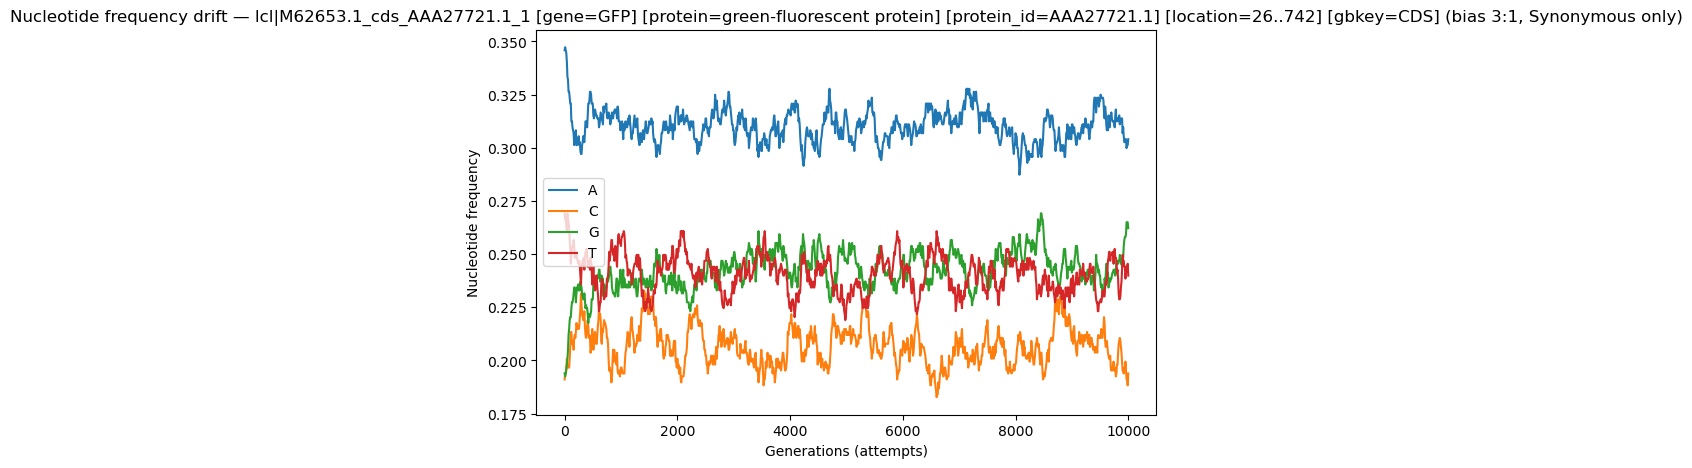

In [11]:
# One-cell notebook version: run drift simulation for EACH gene in a multi-entry FASTA
import random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False   # False = only synonymous; True = allow both
GFP_FASTA = Path("/Users/ishaharris/Projects/ribolings/data/wtGFP.fasta")  # <- set your multi-entry FASTA here

GENERATIONS = 10000           # mutation attempts (accepted tracked separately)
SAMPLE_EVERY = 10             # record frequencies every N attempts
BIAS_TRANSITION = 3.0        # transition:transversion ratio

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F",
    "TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I",
    "ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y",
    "CAT":"H","CAC":"H",
    "CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N",
    "AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D",
    "GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C",
    "TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def translate(cds: str):
    aa = []
    for i in range(0, len(cds), 3):
        codon = cds[i:i+3]
        aa.append(genetic_code.get(codon, "?"))
    return "".join(aa)

def nucleotide_freqs(cds: str):
    c = Counter(cds)
    n = len(cds) if len(cds) > 0 else 1
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base: str, bias_transition: float = 3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds: str, allow_nonsynonymous: bool = False,
                  bias_transition: float = 3.0, max_tries: int = 2000):
    """Single-point mutation attempt on cds."""
    L = len(cds)
    if L < 3:
        return cds, False

    if allow_nonsynonymous:
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            return cds, False
        mutated = cds[:pos] + newb + cds[pos+1:]
        return mutated, True

    # Synonymous-only: try up to max_tries to keep AA unchanged
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        if genetic_code.get(mutated[cs:cs+3]) == genetic_code.get(cds[cs:cs+3]):
            return mutated, True
    return cds, False

# -----------------------------
# Run for each gene in FASTA
# -----------------------------
records = parse_fasta(GFP_FASTA)
print(f"[INFO] Loaded {len(records)} sequence(s) from: {GFP_FASTA}")

mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"
for idx, (name, raw_cds) in enumerate(records.items(), start=1):
    if not raw_cds:
        print(f"[WARN] {idx}/{len(records)} '{name}': empty sequence, skipping.")
        continue

    # Ensure length is multiple of 3
    if len(raw_cds) % 3 != 0:
        cut = len(raw_cds) - (len(raw_cds) % 3)
        print(f"[WARN] {idx}/{len(records)} '{name}': length {len(raw_cds)} not multiple of 3; trimming to {cut}.")
        cds = raw_cds[:cut]
    else:
        cds = raw_cds

    aa_seq = translate(cds)
    print(f"[START] {idx}/{len(records)} '{name}': nt={len(cds)}, aa={len(aa_seq)} | mode={mode_label}")
    print(f"        Progress:")

    history_times = [0]
    history_freqs = [nucleotide_freqs(cds)]
    accepted = 0

    step = max(1, GENERATIONS // 10)
    for gen in range(1, GENERATIONS + 1):
        cds, ok = mutation_step(
            cds,
            allow_nonsynonymous=ALLOW_NONSYNONYMOUS,
            bias_transition=BIAS_TRANSITION,
            max_tries=2000
        )
        if ok:
            accepted += 1
        if gen % SAMPLE_EVERY == 0:
            history_times.append(gen)
            history_freqs.append(nucleotide_freqs(cds))
        if gen % step == 0 or gen == GENERATIONS:
            pct = int(100 * gen / GENERATIONS)
            print(f"          - {pct}% ({gen}/{GENERATIONS}) | accepted={accepted}")

    print(f"[DONE ] '{name}': total accepted mutations = {accepted}")

    # Prepare and plot
    A = [d["A"] for d in history_freqs]
    C = [d["C"] for d in history_freqs]
    G = [d["G"] for d in history_freqs]
    T = [d["T"] for d in history_freqs]

    plt.figure(figsize=(8, 5))
    plt.plot(history_times, A, label="A")
    plt.plot(history_times, C, label="C")
    plt.plot(history_times, G, label="G")
    plt.plot(history_times, T, label="T")
    plt.xlabel("Generations (attempts)")
    plt.ylabel("Nucleotide frequency")
    plt.title(f"Nucleotide frequency drift — {name} (bias 3:1, {mode_label})")
    plt.legend()
    plt.show()


[INFO] Loaded 6 sequence(s) from: /Users/ishaharris/Projects/ribolings/data/GFP.fasta
[START] 1/6 'wtGFP': nt=717, aa=239 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.346 C=0.191 G=0.194 T=0.269
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.315 C=0.197 G=0.236 T=0.252
[DONE ] 'wtGFP': total accepted mutations = 1000


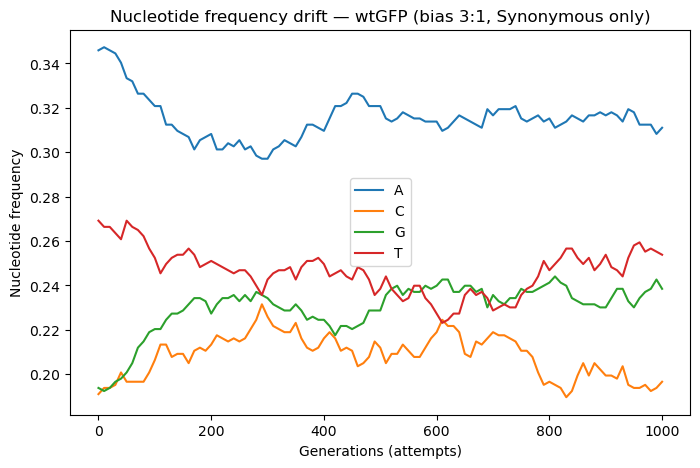

[START] 2/6 'Recoded_Balanced_Mono': nt=717, aa=239 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.257 C=0.245 G=0.251 T=0.247
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.314 C=0.206 G=0.238 T=0.242
[DONE ] 'Recoded_Balanced_Mono': total accepted mutations = 1000


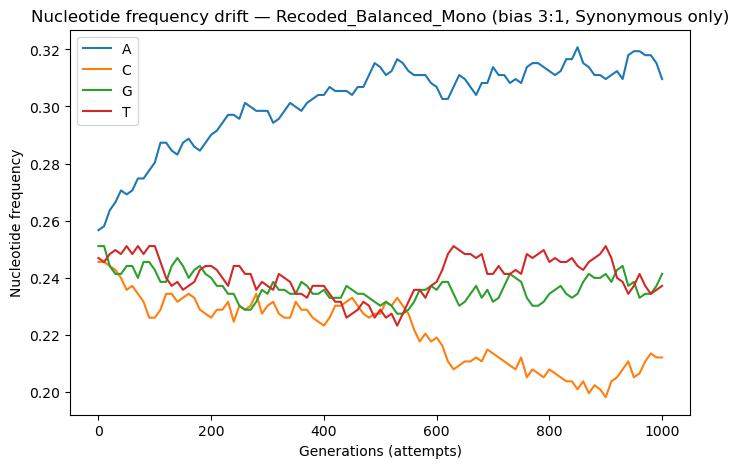

[START] 3/6 'MaxA_Targeted': nt=714, aa=238 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.468 C=0.099 G=0.167 T=0.266
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.323 C=0.202 G=0.245 T=0.230
[DONE ] 'MaxA_Targeted': total accepted mutations = 1000


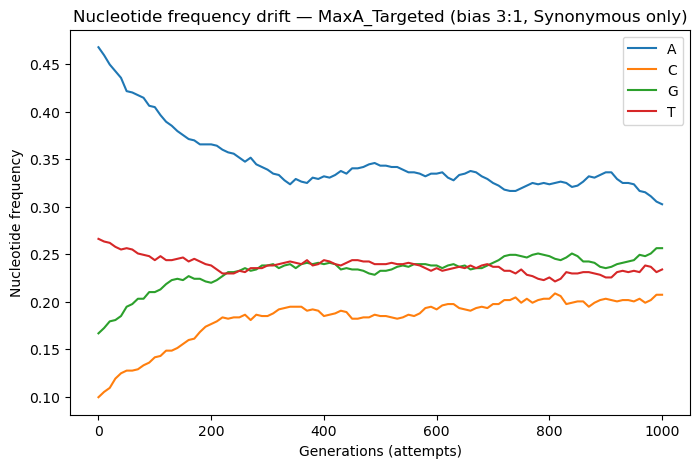

[START] 4/6 'MaxC_Targeted': nt=714, aa=238 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.289 C=0.399 G=0.167 T=0.146
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.295 C=0.221 G=0.235 T=0.248
[DONE ] 'MaxC_Targeted': total accepted mutations = 1000


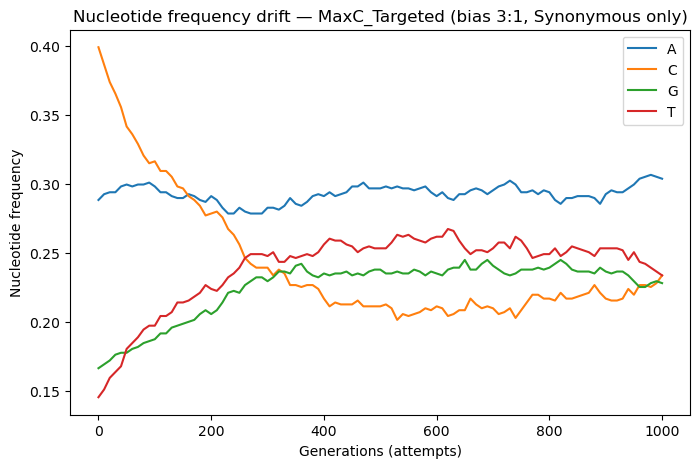

[START] 5/6 'MaxG_Targeted': nt=714, aa=238 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.227 C=0.108 G=0.382 T=0.283
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.311 C=0.213 G=0.240 T=0.236
[DONE ] 'MaxG_Targeted': total accepted mutations = 1000


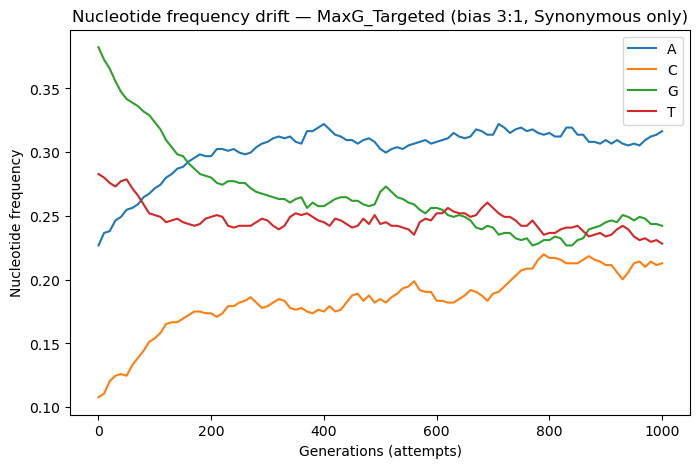

[START] 6/6 'MaxT_Targeted': nt=714, aa=238 | mode=Synonymous only
        Progress:
          • Start freq @ gen 0: A=0.318 C=0.108 G=0.167 T=0.408
          - 10% (100/1000) | accepted=100
          - 20% (200/1000) | accepted=200
          - 30% (300/1000) | accepted=300
          - 40% (400/1000) | accepted=400
          - 50% (500/1000) | accepted=500
          - 60% (600/1000) | accepted=600
          - 70% (700/1000) | accepted=700
          - 80% (800/1000) | accepted=800
          - 90% (900/1000) | accepted=900
          - 100% (1000/1000) | accepted=1000
          • Plateau (avg over last 20%): A=0.301 C=0.215 G=0.235 T=0.250
[DONE ] 'MaxT_Targeted': total accepted mutations = 1000


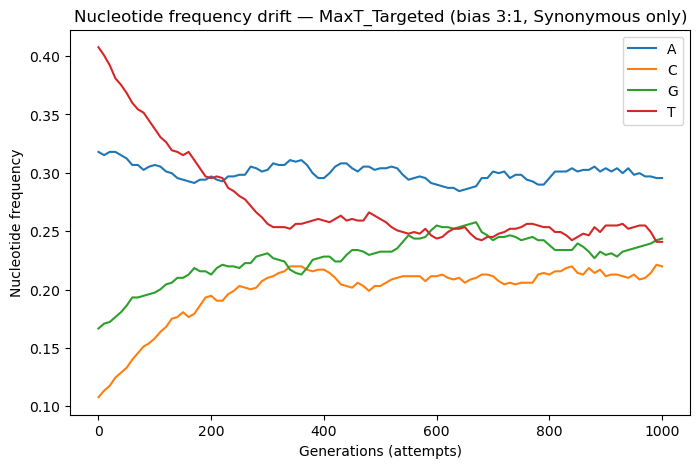

In [16]:
# One-cell notebook version: run drift simulation for EACH gene in a multi-entry FASTA
import random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False   # False = only synonymous; True = allow both
GFP_FASTA = Path("/Users/ishaharris/Projects/ribolings/data/GFP.fasta")  # <- set your multi-entry FASTA here

GENERATIONS = 1000           # mutation attempts (accepted tracked separately)
SAMPLE_EVERY = 10             # record frequencies every N attempts
BIAS_TRANSITION = 3.0         # transition:transversion ratio

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F",
    "TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I",
    "ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y",
    "CAT":"H","CAC":"H",
    "CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N",
    "AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D",
    "GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C",
    "TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def translate(cds: str):
    aa = []
    for i in range(0, len(cds), 3):
        codon = cds[i:i+3]
        aa.append(genetic_code.get(codon, "?"))
    return "".join(aa)

def nucleotide_freqs(cds: str):
    c = Counter(cds)
    n = len(cds) if len(cds) > 0 else 1
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base: str, bias_transition: float = 3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds: str, allow_nonsynonymous: bool = False,
                  bias_transition: float = 3.0, max_tries: int = 2000):
    """Single-point mutation attempt on cds."""
    L = len(cds)
    if L < 3:
        return cds, False

    if allow_nonsynonymous:
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            return cds, False
        mutated = cds[:pos] + newb + cds[pos+1:]
        return mutated, True

    # Synonymous-only: try up to max_tries to keep AA unchanged
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur:
            continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        if genetic_code.get(mutated[cs:cs+3]) == genetic_code.get(cds[cs:cs+3]):
            return mutated, True
    return cds, False

def pretty_freq(d):
    return " ".join(f"{b}={d[b]:.3f}" for b in NUCS)

def mean_freq(dicts):
    if not dicts:
        return {b: float("nan") for b in NUCS}
    s = {b: 0.0 for b in NUCS}
    for d in dicts:
        for b in NUCS:
            s[b] += d[b]
    return {b: s[b]/len(dicts) for b in NUCS}

# -----------------------------
# Run for each gene in FASTA
# -----------------------------
records = parse_fasta(GFP_FASTA)
print(f"[INFO] Loaded {len(records)} sequence(s) from: {GFP_FASTA}")

mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"
for idx, (name, raw_cds) in enumerate(records.items(), start=1):
    if not raw_cds:
        print(f"[WARN] {idx}/{len(records)} '{name}': empty sequence, skipping.")
        continue

    # Ensure length is multiple of 3
    if len(raw_cds) % 3 != 0:
        cut = len(raw_cds) - (len(raw_cds) % 3)
        print(f"[WARN] {idx}/{len(records)} '{name}': length {len(raw_cds)} not multiple of 3; trimming to {cut}.")
        cds = raw_cds[:cut]
    else:
        cds = raw_cds

    aa_seq = translate(cds)
    print(f"[START] {idx}/{len(records)} '{name}': nt={len(cds)}, aa={len(aa_seq)} | mode={mode_label}")
    print(f"        Progress:")

    history_times = [0]
    history_freqs = [nucleotide_freqs(cds)]
    accepted = 0

    # Print starting frequency
    print(f"          • Start freq @ gen 0: {pretty_freq(history_freqs[0])}")

    step = max(1, GENERATIONS // 10)
    for gen in range(1, GENERATIONS + 1):
        cds, ok = mutation_step(
            cds,
            allow_nonsynonymous=ALLOW_NONSYNONYMOUS,
            bias_transition=BIAS_TRANSITION,
            max_tries=2000
        )
        if ok:
            accepted += 1
        if gen % SAMPLE_EVERY == 0:
            history_times.append(gen)
            history_freqs.append(nucleotide_freqs(cds))
        if gen % step == 0 or gen == GENERATIONS:
            pct = int(100 * gen / GENERATIONS)
            print(f"          - {pct}% ({gen}/{GENERATIONS}) | accepted={accepted}")

    # "Plateau" = average frequency across the last 20% of generations (using sampled points)
    cutoff = int(0.8 * GENERATIONS)
    tail_freqs = [f for t, f in zip(history_times, history_freqs) if t >= cutoff]
    plateau = mean_freq(tail_freqs)
    print(f"          • Plateau (avg over last 20%): {pretty_freq(plateau)}")

    print(f"[DONE ] '{name}': total accepted mutations = {accepted}")

    # Prepare and plot
    A = [d["A"] for d in history_freqs]
    C = [d["C"] for d in history_freqs]
    G = [d["G"] for d in history_freqs]
    T = [d["T"] for d in history_freqs]

    plt.figure(figsize=(8, 5))
    plt.plot(history_times, A, label="A")
    plt.plot(history_times, C, label="C")
    plt.plot(history_times, G, label="G")
    plt.plot(history_times, T, label="T")
    plt.xlabel("Generations (attempts)")
    plt.ylabel("Nucleotide frequency")
    title_bias = f"bias {int(BIAS_TRANSITION)}:1" if float(BIAS_TRANSITION).is_integer() else f"bias {BIAS_TRANSITION}:1"
    plt.title(f"Nucleotide frequency drift — {name} ({title_bias}, {mode_label})")
    plt.legend()
    plt.show()


# GFP one panel, matched colours

[INFO] Loaded 3 sequences from /Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta/Peribunya_balanced.fasta
[DONE] lcl|MN119734.1_cds_QDJ95875.1_1 recoded_to_balance_cyclical
[DONE] lcl|MN119735.1_cds_QDJ95876.1_1 recoded_to_balance_cyclical
[DONE] lcl|MN119736.1_cds_QDJ95877.1_1 recoded_to_balance_cyclical


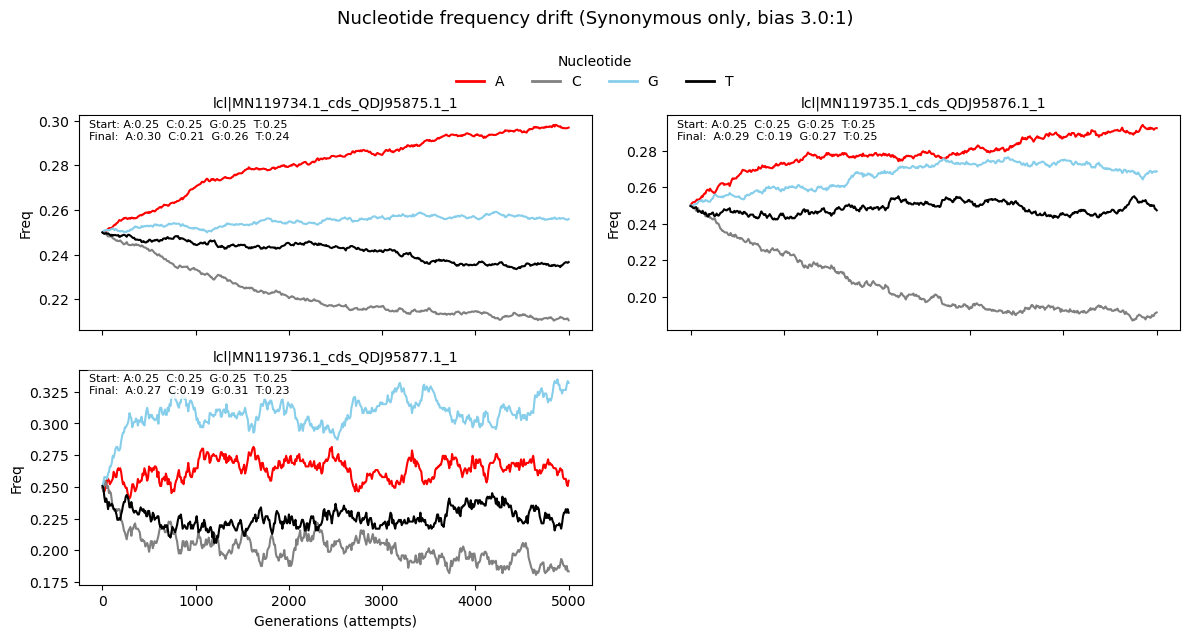

In [7]:
# One-cell notebook version: run drift simulation for EACH gene in a multi-entry FASTA (2-col panel, shared legend, neat summary box)
import random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False
GFP_FASTA = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta/Peribunya_balanced.fasta")

GENERATIONS = 5000
SAMPLE_EVERY = 10
BIAS_TRANSITION = 3.0

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}
COLOURS = {"A": "red", "C": "grey", "G": "skyblue", "T": "black"}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds)
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds, allow_nonsynonymous=False, bias_transition=3.0, max_tries=2000):
    L = len(cds)
    if L < 3: return cds, False
    if allow_nonsynonymous:
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: return cds, False
        return cds[:pos] + newb + cds[pos+1:], True
    # Synonymous-only
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        from_codon = cds[cs:cs+3]
        to_codon = mutated[cs:cs+3]
        if from_codon in genetic_code and to_codon in genetic_code and genetic_code[to_codon] == genetic_code[from_codon]:
            return mutated, True
    return cds, False

def mean_freq(dicts):
    s = {b: 0 for b in NUCS}
    for d in dicts:
        for b in NUCS:
            s[b] += d[b]
    return {b: s[b]/len(dicts) for b in NUCS}

def format_freqs(d):
    return "  ".join(f"{b}:{d[b]:.2f}" for b in NUCS)

# -----------------------------
# Run all and store results
# -----------------------------
records = parse_fasta(GFP_FASTA)
print(f"[INFO] Loaded {len(records)} sequences from {GFP_FASTA}")

mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"
results = {}

for idx, (name, seq) in enumerate(records.items(), 1):
    if not seq:
        continue
    if len(seq) % 3 != 0:
        seq = seq[:len(seq) - len(seq)%3]
        print(f"[WARN] Trimmed {name} to length {len(seq)}")

    cds = seq
    times, freqs = [0], [nucleotide_freqs(cds)]

    for gen in range(1, GENERATIONS + 1):
        cds, ok = mutation_step(cds, ALLOW_NONSYNONYMOUS, BIAS_TRANSITION)
        if gen % SAMPLE_EVERY == 0:
            times.append(gen)
            freqs.append(nucleotide_freqs(cds))

    results[name] = (times, freqs)
    print(f"[DONE] {name}")

# -----------------------------
# Plot all genes (2 columns, shared legend, neat layout)
# -----------------------------
n = len(results)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2*nrows), sharex=True)
axes = axes.flatten()

for ax, (name, (times, freqs)) in zip(axes, results.items()):
    for b in NUCS:
        ax.plot(times, [f[b] for f in freqs], color=COLOURS[b])

    start_avg = freqs[0]
    cutoff = int(0.8 * GENERATIONS)
    tail_freqs = [f for t, f in zip(times, freqs) if t >= cutoff]
    final_avg = mean_freq(tail_freqs)

    text = f"Start: {format_freqs(start_avg)}\nFinal:  {format_freqs(final_avg)}"
    ax.text(
        0.02, 0.98, text, transform=ax.transAxes,
        fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.85, boxstyle="round,pad=0.3", edgecolor='none')
    )

    ax.set_title(name.split()[0], fontsize=10)
    ax.set_ylabel("Freq")

# Turn off unused axes
for ax in axes[len(results):]:
    ax.axis("off")

# Shared legend and labels
handles = [plt.Line2D([0], [0], color=COLOURS[b], lw=2, label=b) for b in NUCS]

fig.suptitle(f"Nucleotide frequency drift ({mode_label}, bias {BIAS_TRANSITION}:1)", fontsize=13, y=0.99)

fig.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.94),  # slightly below title
    ncol=4,
    frameon=False,
    fontsize=10,
    title="Nucleotide"
)

for ax in axes[-ncols:]:
    ax.set_xlabel("Generations (attempts)")

plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave room for title + legend
plt.show()


[INFO] Loaded 72 sequences from /Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta/Calici_balanced.fasta


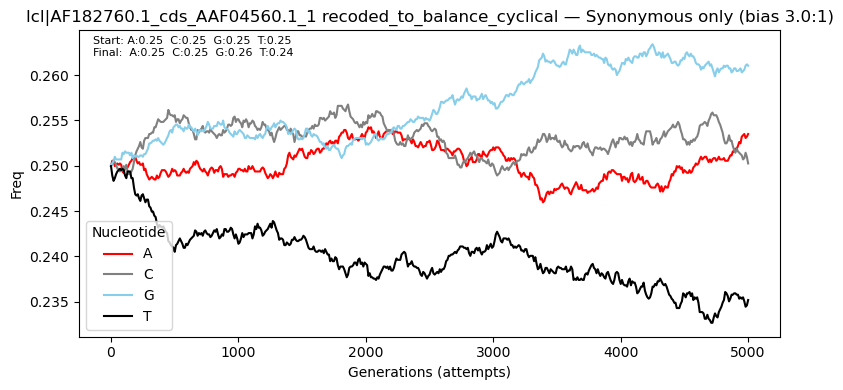

[DONE] lcl|AF182760.1_cds_AAF04560.1_1 recoded_to_balance_cyclical


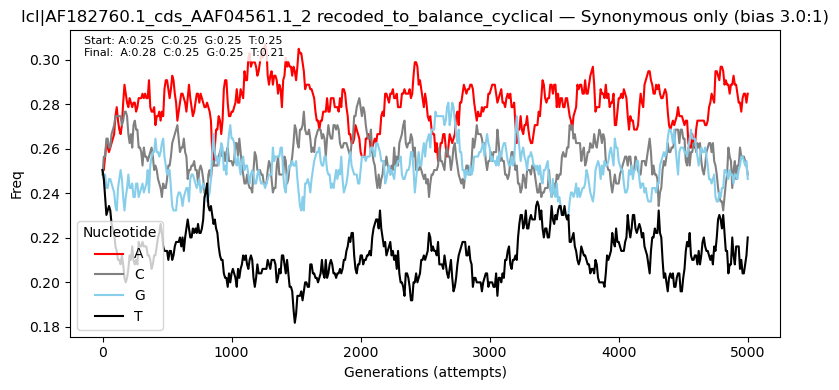

[DONE] lcl|AF182760.1_cds_AAF04561.1_2 recoded_to_balance_cyclical


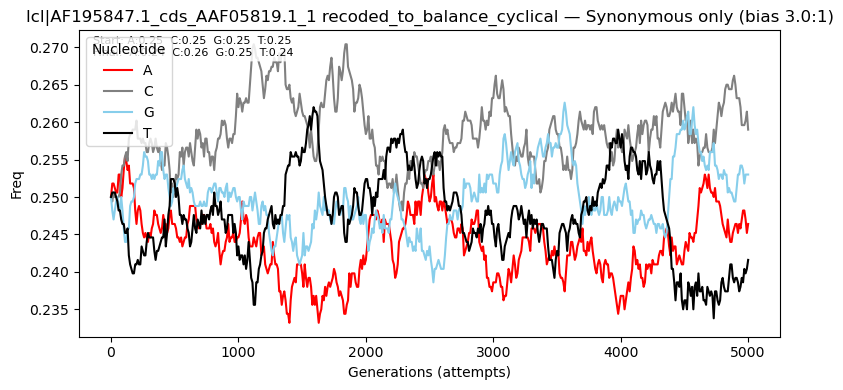

[DONE] lcl|AF195847.1_cds_AAF05819.1_1 recoded_to_balance_cyclical


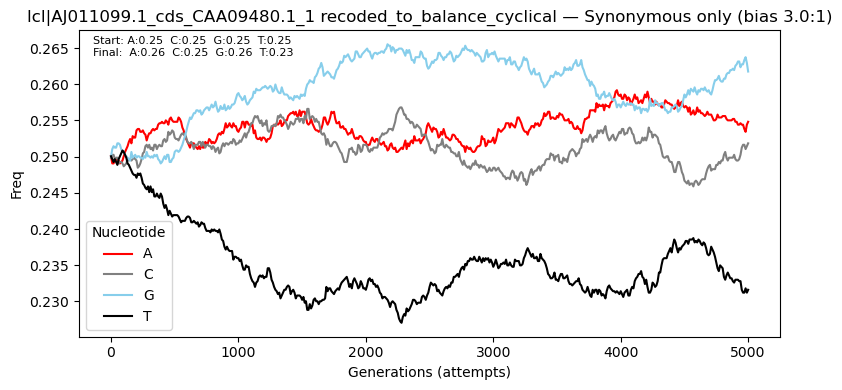

[DONE] lcl|AJ011099.1_cds_CAA09480.1_1 recoded_to_balance_cyclical


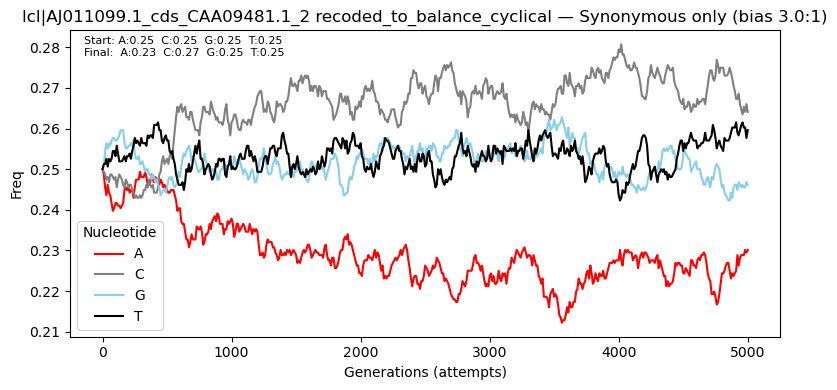

[DONE] lcl|AJ011099.1_cds_CAA09481.1_2 recoded_to_balance_cyclical


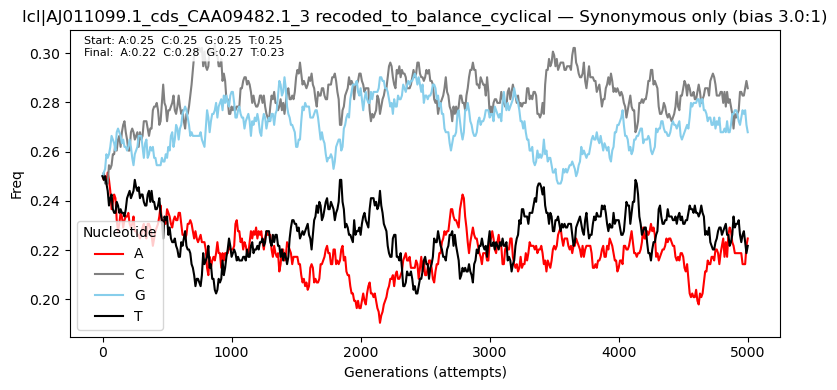

[DONE] lcl|AJ011099.1_cds_CAA09482.1_3 recoded_to_balance_cyclical


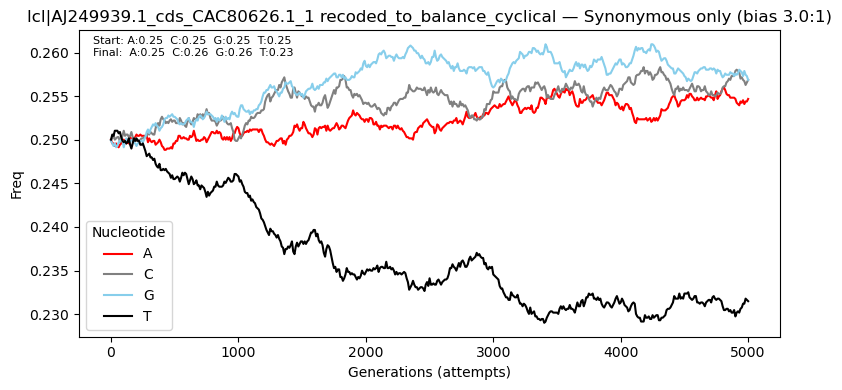

[DONE] lcl|AJ249939.1_cds_CAC80626.1_1 recoded_to_balance_cyclical


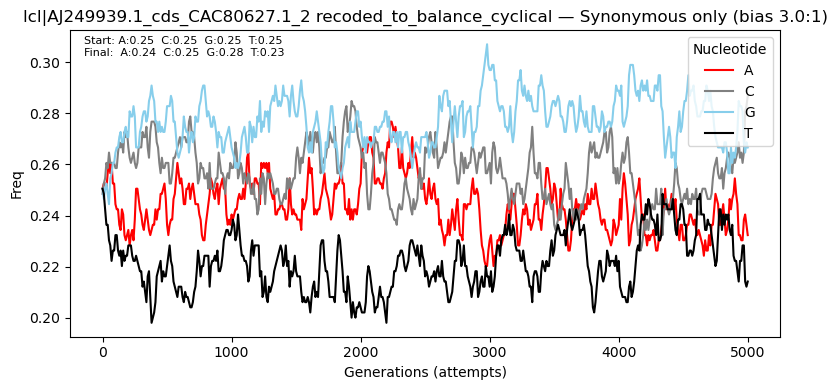

[DONE] lcl|AJ249939.1_cds_CAC80627.1_2 recoded_to_balance_cyclical


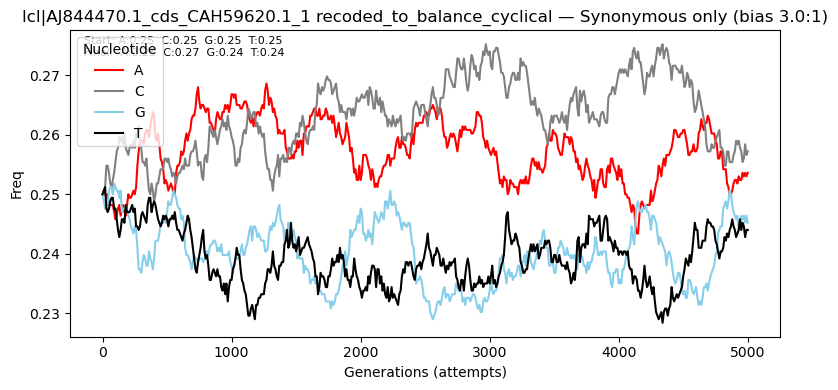

[DONE] lcl|AJ844470.1_cds_CAH59620.1_1 recoded_to_balance_cyclical


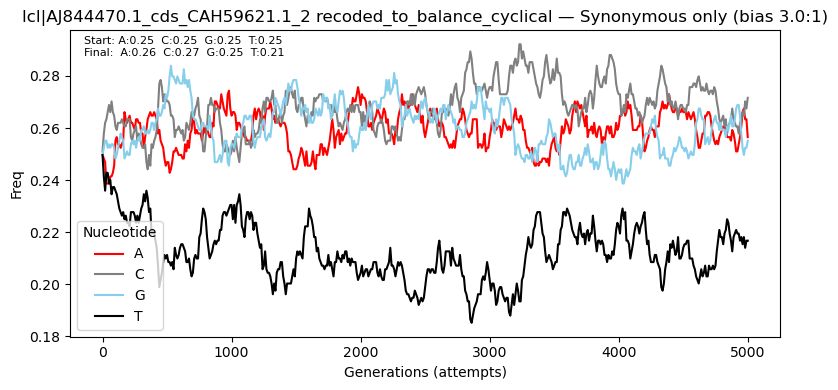

[DONE] lcl|AJ844470.1_cds_CAH59621.1_2 recoded_to_balance_cyclical


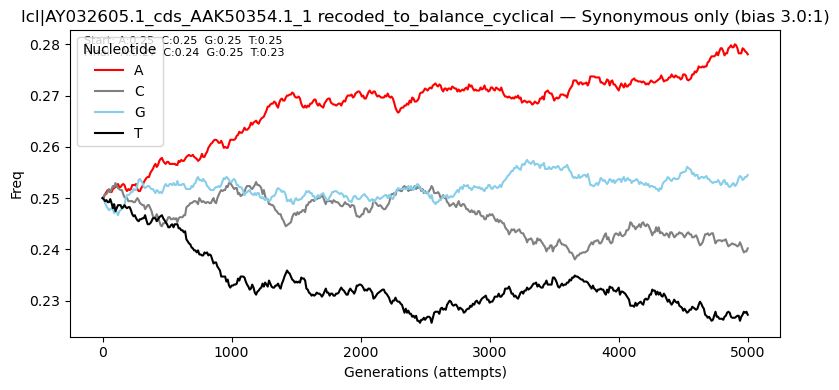

[DONE] lcl|AY032605.1_cds_AAK50354.1_1 recoded_to_balance_cyclical


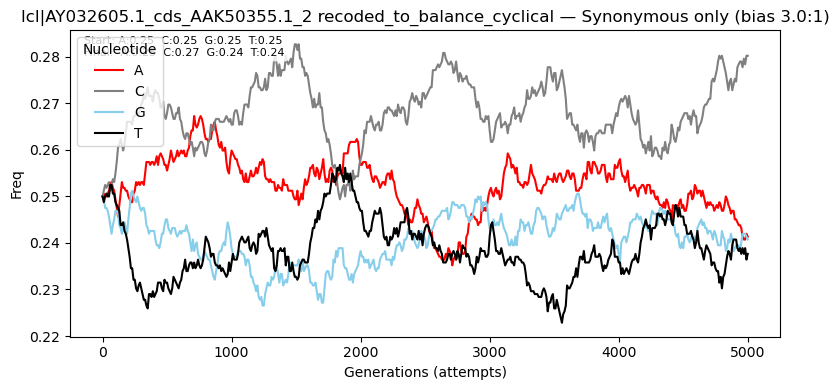

[DONE] lcl|AY032605.1_cds_AAK50355.1_2 recoded_to_balance_cyclical


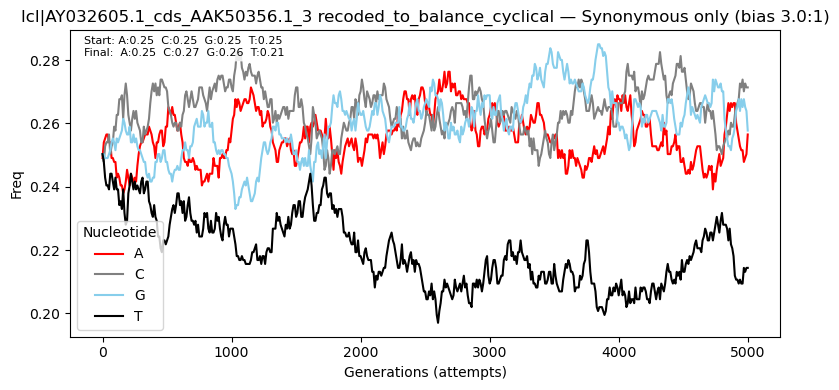

[DONE] lcl|AY032605.1_cds_AAK50356.1_3 recoded_to_balance_cyclical


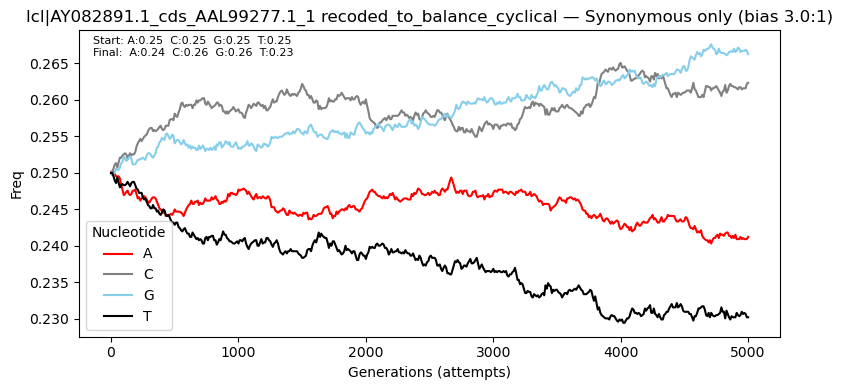

[DONE] lcl|AY082891.1_cds_AAL99277.1_1 recoded_to_balance_cyclical


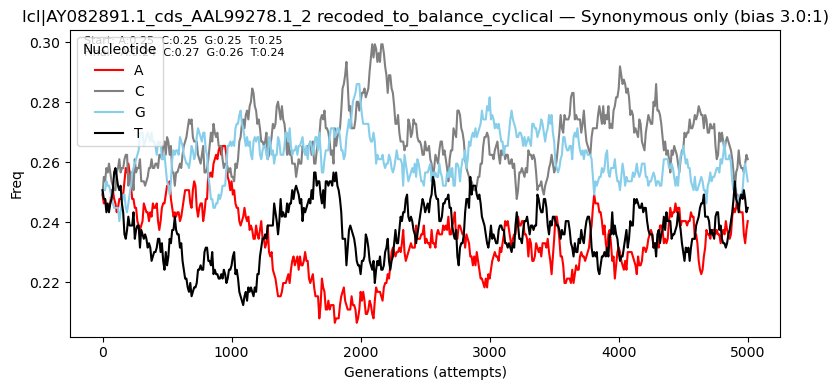

[DONE] lcl|AY082891.1_cds_AAL99278.1_2 recoded_to_balance_cyclical


KeyboardInterrupt: 

In [1]:
# One-cell notebook version: run drift simulation for EACH gene in a multi-entry FASTA (plot one chart per gene)
import random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False
GFP_FASTA = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta/Calici_balanced.fasta")

GENERATIONS = 5000
SAMPLE_EVERY = 10
BIAS_TRANSITION = 3.0

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}
COLOURS = {"A": "red", "C": "grey", "G": "skyblue", "T": "black"}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds)
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds, allow_nonsynonymous=False, bias_transition=3.0, max_tries=2000):
    L = len(cds)
    if L < 3: return cds, False
    if allow_nonsynonymous:
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: return cds, False
        return cds[:pos] + newb + cds[pos+1:], True
    # Synonymous-only
    for _ in range(max_tries):
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        from_codon = cds[cs:cs+3]
        to_codon = mutated[cs:cs+3]
        if from_codon in genetic_code and to_codon in genetic_code and genetic_code[to_codon] == genetic_code[from_codon]:
            return mutated, True
    return cds, False

def mean_freq(dicts):
    s = {b: 0 for b in NUCS}
    for d in dicts:
        for b in NUCS:
            s[b] += d[b]
    return {b: s[b]/len(dicts) for b in NUCS}

def format_freqs(d):
    return "  ".join(f"{b}:{d[b]:.2f}" for b in NUCS)

# -----------------------------
# Run all and plot each gene individually
# -----------------------------
records = parse_fasta(GFP_FASTA)
print(f"[INFO] Loaded {len(records)} sequences from {GFP_FASTA}")

mode_label = "Synonymous only" if not ALLOW_NONSYNONYMOUS else "Synonymous + non-synonymous"

for idx, (name, seq) in enumerate(records.items(), 1):
    if not seq:
        continue
    if len(seq) % 3 != 0:
        seq = seq[:len(seq) - len(seq)%3]
        print(f"[WARN] Trimmed {name} to length {len(seq)}")

    cds = seq
    times, freqs = [0], [nucleotide_freqs(cds)]

    for gen in range(1, GENERATIONS + 1):
        cds, ok = mutation_step(cds, ALLOW_NONSYNONYMOUS, BIAS_TRANSITION)
        if gen % SAMPLE_EVERY == 0:
            times.append(gen)
            freqs.append(nucleotide_freqs(cds))

    # Plot this gene
    plt.figure(figsize=(8, 4))
    for b in NUCS:
        plt.plot(times, [f[b] for f in freqs], color=COLOURS[b], label=b)

    start_avg = freqs[0]
    cutoff = int(0.8 * GENERATIONS)
    tail_freqs = [f for t, f in zip(times, freqs) if t >= cutoff]
    final_avg = mean_freq(tail_freqs)

    text = f"Start: {format_freqs(start_avg)}\nFinal:  {format_freqs(final_avg)}"
    plt.gca().text(
        0.02, 0.98, text, transform=plt.gca().transAxes,
        fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.85, boxstyle="round,pad=0.3", edgecolor='none')
    )

    plt.title(f"{name} — {mode_label} (bias {BIAS_TRANSITION}:1)")
    plt.ylabel("Freq")
    plt.xlabel("Generations (attempts)")
    plt.legend(title="Nucleotide")
    plt.tight_layout()
    plt.show()
    print(f"[DONE] {name}")


Residual A -richness plot

In [1]:
# --- Residual A-richness bar plot: ΔA = start − final 20% average ---
residuals = []
for name, (times, freqs) in results.items():
    startA = freqs[0]["A"]
    cutoff = int(0.8 * GENERATIONS)
    tail = [f for t, f in zip(times, freqs) if t >= cutoff]
    if not tail:
        continue
    finalA = sum(f["A"] for f in tail) / len(tail)
    residuals.append((name, startA - finalA))  # start − final20%

# Sort by residual
residuals.sort(key=lambda x: x[1])
names = [n for n, _ in residuals]
vals = [v for _, v in residuals]

import numpy as np
import matplotlib.pyplot as plt

y = np.arange(len(vals))
plt.figure(figsize=(6.2, 0.38 * len(vals) + 1.2))
colors = np.where(np.array(vals) >= 0, "#03ae3c", "tab:red")  # green if A decreased
plt.barh(y, vals, color=colors, edgecolor="black", linewidth=0.6)

plt.yticks(y, names)
plt.axvline(0, color="black", linewidth=2)
plt.xlabel("ΔA (start − final 20% avg)")
plt.title("Residual A-richness per GFP")

m = max(abs(min(vals)), abs(max(vals))) if vals else 0.01
plt.xlim(-1.1 * m, 1.1 * m)
plt.tight_layout()
plt.show()


NameError: name 'results' is not defined

# Loop through all virus families

In [5]:
# One-cell: compute start and final A-richness per-sequence and per-FASTA (virus family, subsettable)
import random
from collections import Counter
from pathlib import Path
import math

# -----------------------------
# Config (edit these)
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False
FASTA_DIR = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta")  # folder containing *.fasta
FAMILIES = ['Arena', 'Calici', 'Corona', 'Filo', 'Flavi', 'Hanta', 'Picorna', 'Orthomyxo', 'Paramyxo', 'Peribunya','Rhabdo']  

GENERATIONS = 1000
SAMPLE_EVERY = 10
BIAS_TRANSITION = 3.0

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}
NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds) if len(cds)>0 else 1
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds, allow_nonsynonymous=False, bias_transition=3.0, max_tries=2000):
    L = len(cds)
    if L < 3: return cds, False
    if allow_nonsynonymous:
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: return cds, False
        return cds[:pos] + newb + cds[pos+1:], True
    for _ in range(max_tries):  # synonymous-only
        pos = random.randrange(L)
        cur = cds[pos]
        newb = choose_mutant_base(cur, bias_transition)
        if newb == cur: continue
        mutated = cds[:pos] + newb + cds[pos+1:]
        cs = (pos // 3) * 3
        from_codon, to_codon = cds[cs:cs+3], mutated[cs:cs+3]
        if from_codon in genetic_code and to_codon in genetic_code and genetic_code[to_codon] == genetic_code[from_codon]:
            return mutated, True
    return cds, False

def run_drift_for_sequence(seq):
    if len(seq) % 3 != 0:
        seq = seq[:len(seq) - len(seq)%3]
    cds = seq
    times, freqs = [0], [nucleotide_freqs(cds)]
    for gen in range(1, GENERATIONS + 1):
        cds, _ = mutation_step(cds, ALLOW_NONSYNONYMOUS, BIAS_TRANSITION)
        if gen % SAMPLE_EVERY == 0:
            times.append(gen)
            freqs.append(nucleotide_freqs(cds))
    cutoff = int(0.8 * GENERATIONS)
    tail_freqs = [f for t,f in zip(times, freqs) if t >= cutoff]
    final_A = sum(f["A"] for f in tail_freqs) / len(tail_freqs) if tail_freqs else freqs[-1]["A"]
    start_A = freqs[0]["A"]
    return start_A, final_A

# -----------------------------
# Run families
# -----------------------------

all_fastas = sorted(FASTA_DIR.glob("*_balanced.fasta"))

if FAMILIES:
    # Keep only files whose names start with one of the family names
    fasta_files = [f for f in all_fastas if any(f.name.startswith(fam) for fam in FAMILIES)]
else:
    fasta_files = all_fastas

if not fasta_files:
    print(f"[ERROR] No FASTA files selected in {FASTA_DIR}")
else:
    for fasta in fasta_files:
        records = parse_fasta(fasta)
        if not records:
            print(f"[WARN] {fasta.name} contains no sequences, skipping.")
            continue

        seq_starts, seq_finals = [], []
        print(f"\n[FAMILY] {fasta.name}  -- {len(records)} sequences")
        for i,(name, seq) in enumerate(records.items(), 1):
            if not seq or len(seq)<3: continue
            if len(seq) % 3 != 0: seq = seq[:len(seq) - len(seq)%3]
            start_A, final_A = run_drift_for_sequence(seq)
            seq_starts.append(start_A); seq_finals.append(final_A)
            print(f"  {i:3d}. Processing {name} ")

        mean_start = sum(seq_starts)/len(seq_starts) if seq_starts else math.nan
        mean_final = sum(seq_finals)/len(seq_finals) if seq_finals else math.nan
        print(f"  --> FAMILY MEAN: start_A = {mean_start:.3f}   final_A = {mean_final:.3f}")



[FAMILY] Arena_balanced.fasta  -- 249 sequences
    1. Processing lcl|AB586644.1_cds_BAL03411.1_1 recoded_to_balance_cyclical 


    2. Processing lcl|AB586644.1_cds_BAL03412.1_2 recoded_to_balance_cyclical 
    3. Processing lcl|AB586645.1_cds_BAL03413.1_1 recoded_to_balance_cyclical 
    4. Processing lcl|AB586645.1_cds_BAL03414.1_2 recoded_to_balance_cyclical 
    5. Processing lcl|AB693150.1_cds_BAM45328.1_1 recoded_to_balance_cyclical 
    6. Processing lcl|AB693150.1_cds_BAM45329.1_2 recoded_to_balance_cyclical 
    7. Processing lcl|AB693151.1_cds_BAM45330.1_1 recoded_to_balance_cyclical 
    8. Processing lcl|AB693151.1_cds_BAM45331.1_2 recoded_to_balance_cyclical 
    9. Processing lcl|AB972428.1_cds_BAU22152.1_1 recoded_to_balance_cyclical 
   10. Processing lcl|AB972429.1_cds_BAU22153.1_1 recoded_to_balance_cyclical 
   11. Processing lcl|AB972430.1_cds_BAU22154.1_1 recoded_to_balance_cyclical 
   12. Processing lcl|AB972431.1_cds_BAU22155.1_1 recoded_to_balance_cyclical 
   13. Processing lcl|AF228063.1_cds_AAK60497.1_1 recoded_to_balance_cyclical 
   14. Processing lcl|AF228063.1_cds_AAK60498.1_2 re

Starting analysis...
Found 11 fasta files for selected families.

[FAMILY] Arena_balanced.fasta
  Parsed 249 sequences from Arena_balanced.fasta
  Sequence 1/249  Start: {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}  -->  Final: {'A': 0.2936830558781779, 'C': 0.23541747322235132, 'G': 0.1945089688992128, 'T': 0.2763905020002581}
  Sequence 2/249  Start: {'A': 0.2504378283712785, 'C': 0.24985405720957385, 'G': 0.24985405720957385, 'T': 0.24985405720957385}  -->  Final: {'A': 0.2824896450115364, 'C': 0.2325355127456703, 'G': 0.24710199316153783, 'T': 0.23787284908125533}
  Sequence 3/249  Start: {'A': 0.25252525252525254, 'C': 0.24915824915824916, 'G': 0.24915824915824916, 'T': 0.24915824915824916}  -->  Final: {'A': 0.2998236331569665, 'C': 0.25701459034792373, 'G': 0.21596921596921598, 'T': 0.2271925605258939}
  Sequence 4/249  Start: {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}  -->  Final: {'A': 0.2622270930032663, 'C': 0.24048048822417054, 'G': 0.23836742880064182, 'T': 0.25892498997

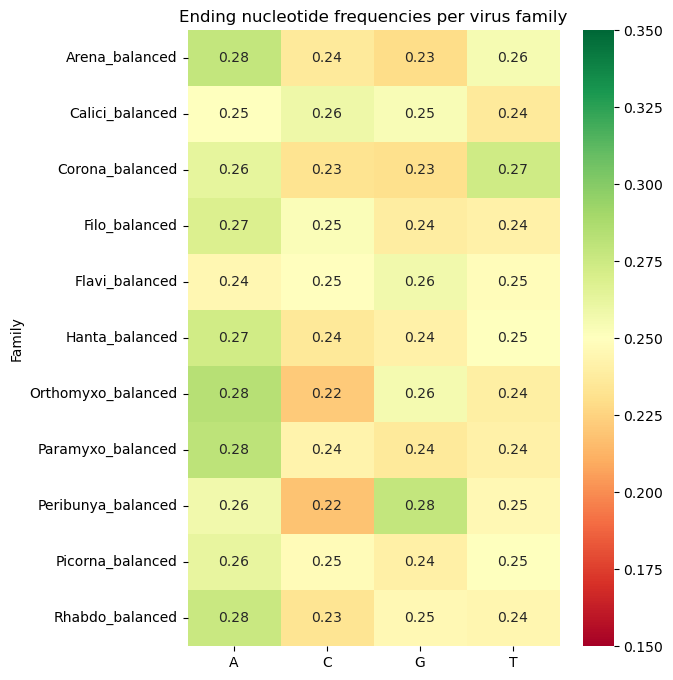

Heatmap displayed.


In [1]:
import random
from collections import Counter
from pathlib import Path
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

ALLOW_NONSYNONYMOUS = False
FASTA_DIR = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta")
FAMILIES = ['Arena', 'Calici', 'Corona', 'Filo', 'Flavi', 'Hanta', 'Picorna', 'Orthomyxo', 'Paramyxo', 'Peribunya','Rhabdo']

GENERATIONS = 1000
SAMPLE_EVERY = 10
BIAS_TRANSITION = 3.0
NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

# Genetic code for synonymous mutations
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

# -----------------------------
# Functions
# -----------------------------
def parse_fasta(filename):
    records = {}
    header, seq_chunks = None, []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith(">"):
                if header and seq_chunks: records[header] = "".join(seq_chunks).upper().replace("U","T")
                header, seq_chunks = line[1:].strip(), []
            else: seq_chunks.append(line)
        if header and seq_chunks: records[header] = "".join(seq_chunks).upper().replace("U","T")
    print(f"  Parsed {len(records)} sequences from {filename.name}")
    return records

def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds) if len(cds)>0 else 1
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutation_step(cds, allow_nonsynonymous=False, bias_transition=3.0, max_tries=2000):
    L = len(cds)
    if L<3: return cds, False
    if allow_nonsynonymous:
        pos = random.randrange(L)
        newb = choose_mutant_base(cds[pos], bias_transition)
        return cds[:pos]+newb+cds[pos+1:], True
    for _ in range(max_tries):
        pos = random.randrange(L)
        newb = choose_mutant_base(cds[pos], bias_transition)
        if newb==cds[pos]: continue
        mutated = cds[:pos]+newb+cds[pos+1:]
        cs = (pos//3)*3
        if genetic_code.get(mutated[cs:cs+3]) == genetic_code.get(cds[cs:cs+3]):
            return mutated, True
    return cds, False

def run_drift_for_sequence(seq):
    if len(seq)%3!=0: seq = seq[:len(seq)-len(seq)%3]
    cds = seq
    times, freqs = [0], [nucleotide_freqs(cds)]
    for gen in range(1, GENERATIONS+1):
        cds, _ = mutation_step(cds, ALLOW_NONSYNONYMOUS, BIAS_TRANSITION)
        if gen % SAMPLE_EVERY == 0:
            times.append(gen)
            freqs.append(nucleotide_freqs(cds))
    cutoff = int(0.8*GENERATIONS)
    tail_freqs = [f for t,f in zip(times,freqs) if t>=cutoff]
    final_freq = {b: sum(f[b] for f in tail_freqs)/len(tail_freqs) for b in NUCS} if tail_freqs else freqs[-1]
    return freqs[0], final_freq

# -----------------------------
# Run analysis
# -----------------------------
print("Starting analysis...")
all_fastas = sorted(FASTA_DIR.glob("*_balanced.fasta"))
fasta_files = [f for f in all_fastas if any(f.name.startswith(fam) for fam in FAMILIES)]
print(f"Found {len(fasta_files)} fasta files for selected families.")

results = []

for fasta in fasta_files:
    print(f"\n[FAMILY] {fasta.name}")
    records = parse_fasta(fasta)
    start_list, final_list = [], []
    for i, seq in enumerate(records.values(), 1):
        if len(seq)<3: continue
        start_freq, final_freq = run_drift_for_sequence(seq)
        print(f"  Sequence {i}/{len(records)}  Start: {start_freq}  -->  Final: {final_freq}")
        start_list.append(start_freq)
        final_list.append(final_freq)
    mean_start = {b: sum(d[b] for d in start_list)/len(start_list) for b in NUCS}
    mean_final = {b: sum(d[b] for d in final_list)/len(final_list) for b in NUCS}
    results.append({"Family": fasta.stem, **{f"start_{b}":mean_start[b] for b in NUCS}, **{f"final_{b}":mean_final[b] for b in NUCS}})
    print(f"  Finished family {fasta.stem}. Mean start: {mean_start}, Mean final: {mean_final}")

df = pd.DataFrame(results)
df.to_csv("virus_nt_freqs.csv", index=False)
print("Saved results to virus_nt_freqs.csv")

# -----------------------------
# Heatmap for final frequencies
# -----------------------------
print("Generating heatmap...")
heatmap_data = df.set_index("Family")[[f"final_{b}" for b in NUCS]]
heatmap_data.columns = NUCS
plt.figure(figsize=(6,8))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", vmin=0.15, vmax=0.35)
plt.title("Ending nucleotide frequencies per virus family")
plt.show()
print("Heatmap displayed.")


# Residual simulation